In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import math as mt
from sympy import symbols, diff
from scipy.misc import derivative
from scipy.integrate import simps 
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
from scipy.integrate import trapz

In [2]:
# Leitura dos dados do arquivo data.dat
data = pd.read_csv('Ogiva.dat', sep='\s+', header=None, names=['x', 'y'])
pd.set_option('display.float_format', '{:.6f}'.format)

# Gráfico da ogina bidimensional

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


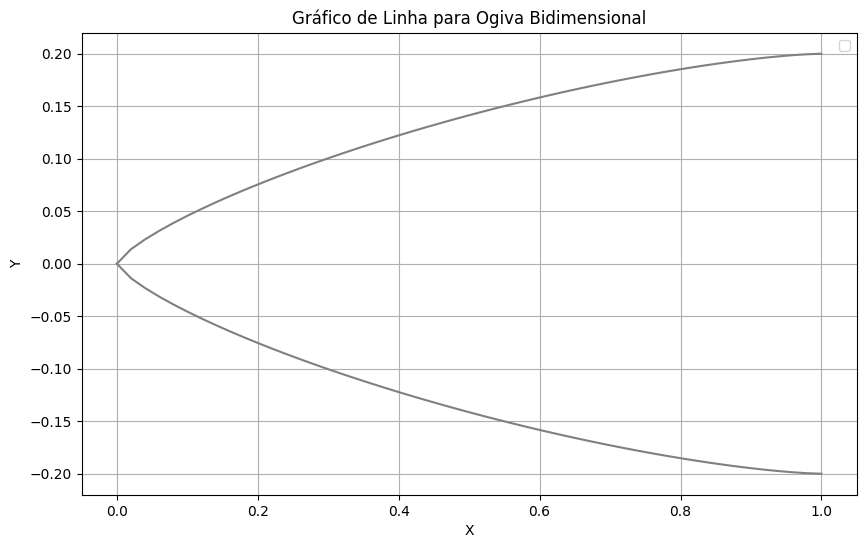

In [3]:
# Plotando um gráfico de linha para a ogiva bidimensional
plt.figure(figsize=(10, 6))
plt.plot(data['x'], data['y'], color='grey')
plt.plot(data['x'], -data['y'], color='grey')
plt.title('Gráfico de Linha para Ogiva Bidimensional')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

## Descrição do problema:
Considere um escoamento hipersônico, cujo número de Mach de corrente livre é M<sub>∞</sub> = 10, incidindo com ângulo de ataque nulo sobre uma ogiva bidimensional simétrica. A superfície superior da ogiva é descrita pelas equações (1) e (2), com as seguintes dimensões: L = 1 e R = 0.2.

Admitindo que a razão de γ = 1.4:

#### a) A distribuição de Cp sobre a superfície do corpo em função de sua posição x/L, utilizando os métodos de inclinação de superfície Newtoniano, Newtoniano modificado e Busemann–Newtoniano.Apresente os resultados por meio de gráficos x/L × Cp.

In [4]:
#Dados do enunciado

# Definindo constantes e parâmetros do problema
gamma = 1.4  # Razão de calores específicos
M_inf = 10   # Número de Mach de corrente livre
L = 1        # Comprimento característico
R = 0.2


In [5]:
# Função para calcular o ângulo theta
def calculo_theta(x, L):
    return  np.arccos((1 - ((2 * x) / L)))

#Funcao para calcular o y
def calcula_y(x, L, R):
    theta = calculo_theta(x, L)
    return (R / np.sqrt(np.pi) ) * np.sqrt(theta - (np.sin(2 * theta) / 2) )


# Funções para calcular Cp para cada método
def cp_newton(dy_dx):
    return 2 * np.sin(dy_dx)**2

def cp_newton_modificado(dy_dx, gamma, M_inf):
    Cpm_max = (2 / (gamma * (M_inf**2))) * ( (( (((gamma + 1) ** 2) * (M_inf**2) ) / ( (4*gamma* (M_inf**2)) - 2 * (gamma - 1) ) ) ** (gamma / (gamma - 1)) ) * ( ((1 - gamma + (2*gamma*(M_inf**2)) ) /  (gamma + 1)) - 1 ) )
    return Cpm_max * np.sin(dy_dx)**2

def cp_busemann_newton(dy_dx, dtheta_dy, dy, integral):
    return (2*(np.sin(dy_dx)**2)) + 2*(dtheta_dy)*np.sin(dy_dx)*np.cos(dy_dx)*dy


# Função para calcular o coeficiente de arrasto de onda
def calcular_cd(data, cp_col, num_pontos=1000):
    # Interpolando os dados para aumentar a discretização
    x_interpolado = np.linspace(data['x'].min(), data['x'].max(), num_pontos)
    cp_interp = interp1d(data['x'], data[cp_col], kind='cubic')(x_interpolado)
    dy_dx_interp = interp1d(data['x'], data['dy_dx'], kind='cubic')(x_interpolado)

    # Calculando a integral com maior discretização
    integrand = cp_interp * dy_dx_interp
    cd = 2 * simps(integrand, x_interpolado)

    return cd

def calcular_derivada_gradient(data, col_y, col_x):
    """Calcula a derivada usando numpy.gradient."""
    dy_dx = np.gradient(data[col_y], data[col_x])
    return dy_dx

def calcular_derivada_diff(data, col_y, col_x):
    """Calcula a derivada usando diff."""
    delta_y = data[col_y].diff()
    delta_x = data[col_x].diff()
    dy_dx = delta_y / delta_x
    return dy_dx.shift(-1)  # Deslocar para alinhar com os valores originais

def calcular_dtheta_dy(data, col_theta):
    """Calcula a derivada de theta em relação a y."""
    delta_theta = data[col_theta].diff()
    delta_y = data['y'].diff()
    dtheta_dy = delta_theta / delta_y
    return dtheta_dy.shift(-1)  # Deslocar para alinhar com os valores originais

def calcular_integral_cos_theta(data, col_theta):
    """Calcula a integral de cos(theta) multiplicada por dy."""
    cos_theta = np.cos(data[col_theta])
    dy = data['y'].diff()
    integral = cos_theta * dy.shift(-1)  # Deslocar para alinhar com os valores originais
    return integral


def calcular_delta_y(data, col_y):
    """Calcula a diferença entre valores consecutivos de y."""
    delta_y = data[col_y].diff()
    return delta_y.shift(-1)  # Deslocar para alinhar com os valores originais


In [6]:

data['dy'] = calcular_delta_y(data, 'y')
data['dy_dx'] = calcular_derivada_diff(data, 'y', 'x')
data['dtheta_dy'] = calcular_dtheta_dy(data, 'dy_dx')
data['integral'] = calcular_integral_cos_theta(data, 'dy_dx')


data['cp_newton'] = cp_newton(data['dy_dx'])
data['cp_newton_modificado'] = cp_newton_modificado(data['dy_dx'], gamma, M_inf)  
data['Cp_Busemann_Newton'] = cp_busemann_newton(data['dy_dx'], data['dtheta_dy'], data['dy'], data['integral'])

data['dy_dx'].fillna(0, inplace=True)
data['cp_newton'].fillna(0, inplace=True)
data['cp_newton_modificado'].fillna(0, inplace=True)
data['Cp_Busemann_Newton'].fillna(0, inplace=True)

# Recalculando cd para cada método com os dados corrigidos
cd_newton = calcular_cd(data, 'cp_newton')
cd_newton_modificado = calcular_cd(data, 'cp_newton_modificado')
cd_busemann_newton = calcular_cd(data, 'Cp_Busemann_Newton')

cd_newton, cd_newton_modificado, cd_busemann_newton 

(0.056314444461052875, 0.05153085817910182, 0.05151781841787528)

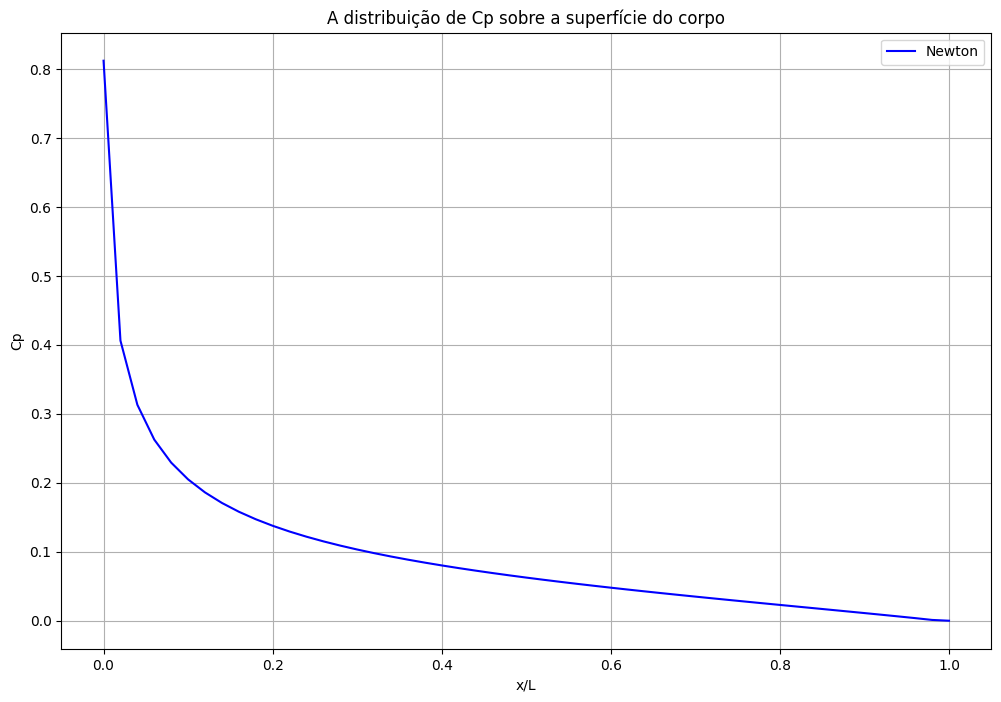

In [7]:
# Criando gráficos x/L × Cp
plt.figure(figsize=(12, 8))
plt.plot(data['x'] / L, data['cp_newton'], label='Newton', color='blue')
plt.xlabel('x/L')
plt.ylabel('Cp')
plt.title('A distribuição de Cp sobre a superfície do corpo')
plt.legend()
plt.grid(True)
plt.show()


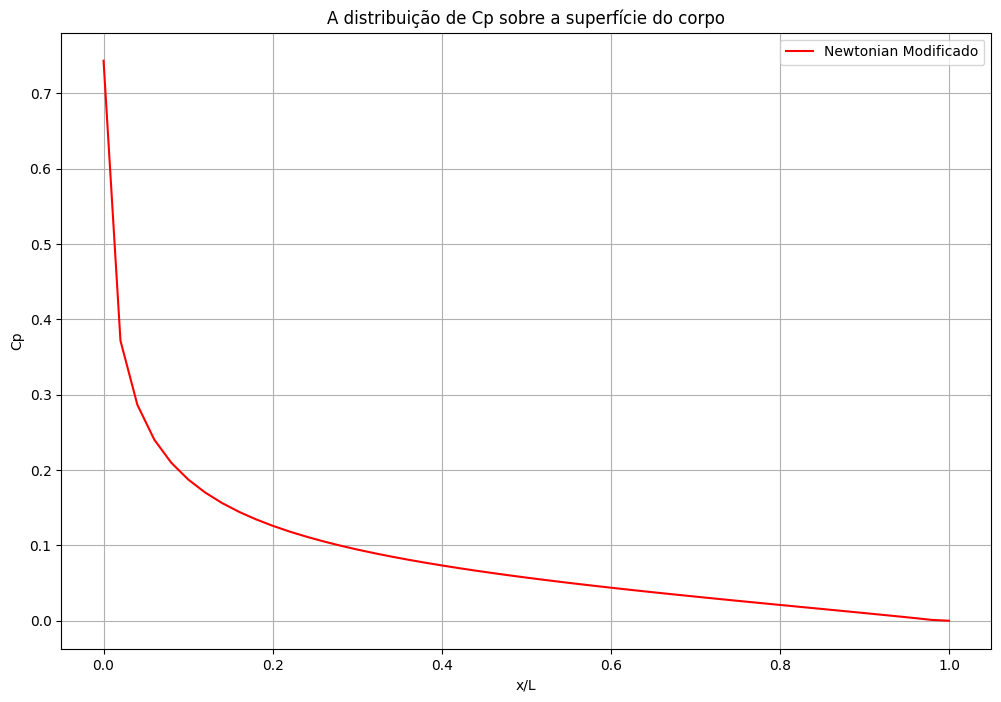

In [8]:
# Criando gráficos x/L × Cp
plt.figure(figsize=(12, 8))
plt.plot(data['x'] / L, data['cp_newton_modificado'], label='Newtonian Modificado', color='red')
plt.xlabel('x/L')
plt.ylabel('Cp')
plt.title('A distribuição de Cp sobre a superfície do corpo')
plt.legend()
plt.grid(True)
plt.show()

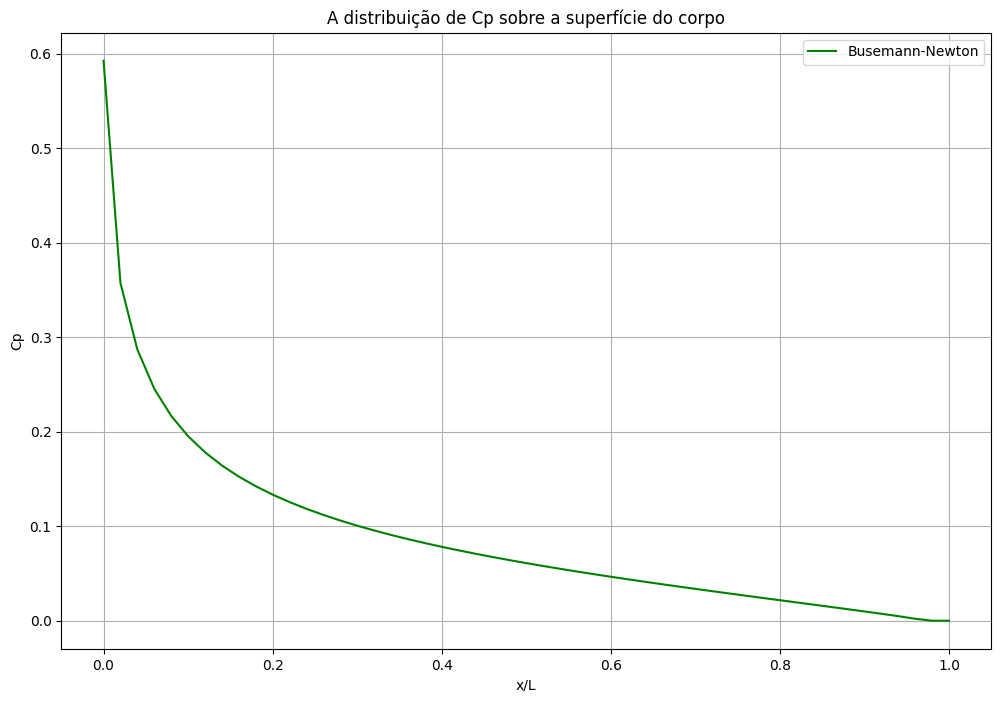

In [9]:
# Criando gráficos x/L × Cp
plt.figure(figsize=(12, 8))
plt.plot(data['x'] / L, data['Cp_Busemann_Newton'], label='Busemann-Newton', color='green')
plt.xlabel('x/L')
plt.ylabel('Cp')
plt.title('A distribuição de Cp sobre a superfície do corpo')
plt.legend()
plt.grid(True)
plt.show()


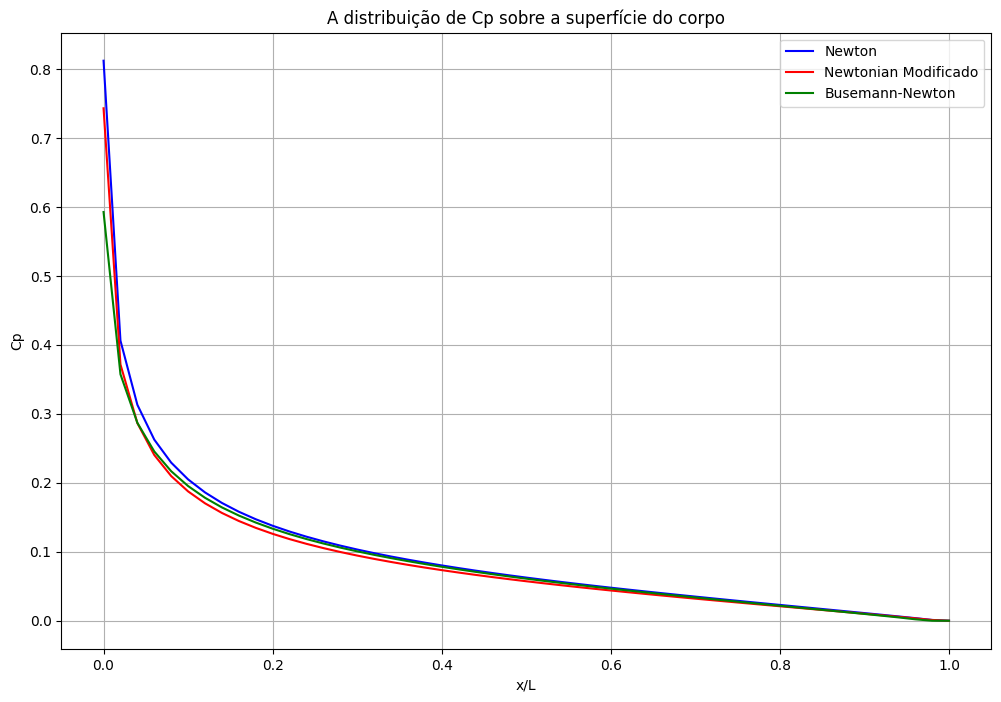

In [10]:

# Criando gráficos x/L × Cp
plt.figure(figsize=(12, 8))
plt.plot(data['x'] / L, data['cp_newton'], label='Newton', color='blue')
plt.plot(data['x'] / L, data['cp_newton_modificado'], label='Newtonian Modificado', color='red')
plt.plot(data['x'] / L, data['Cp_Busemann_Newton'], label='Busemann-Newton', color='green')
plt.xlabel('x/L')
plt.ylabel('Cp')
plt.title('A distribuição de Cp sobre a superfície do corpo')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#Printando os valores de Cd
print('O valor de Cd para o método de Newton é: ', cd_newton)
print('O valor de Cd para o método de Newton Modificado é: ', cd_newton_modificado)
print('O valor de Cd para o método de Busemann-Newton é: ', cd_busemann_newton)



O valor de Cd para o método de Newton é:  0.056314444461052875
O valor de Cd para o método de Newton Modificado é:  0.05153085817910182
O valor de Cd para o método de Busemann-Newton é:  0.05151781841787528
